In [2]:
import os
import sys
sys.path.append('../../..')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import joblib
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import feature_column as fc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn import preprocessing
from sklearn.utils import shuffle
from tensorflow.keras.models import save_model,load_model

from utils.util import *
from utils.preprocessing import *
from utils.dataiter import Dataiter
from utils.evaluate import calculate_ctr, compute_rce, average_precision_score
from utils.target_encode import MTE_one_shot

import tensorflow.keras.backend as K
import core.config as conf

## Load Data

In [3]:
path = f'{conf.dataset_mini_path}/train'
train = read_data(path)

path = f'{conf.dataset_mini_path}/test'
test = read_data(path)

path = f'{conf.dataset_mini_path}/valid'
valid = read_data(path)

In [4]:
TARGET = 'reply'

## Preprocessing

In [5]:
def set_dataframe_types(df, train):
    df['id']   = np.arange( df.shape[0] )
    df['id']   = df['id'].astype(np.uint32)

    if train:
        df['reply_timestamp']   = df['reply_timestamp'].fillna(0)
        df['retweet_timestamp'] = df['retweet_timestamp'].fillna(0)
        df['comment_timestamp'] = df['comment_timestamp'].fillna(0)
        df['like_timestamp']    = df['like_timestamp'].fillna(0)

        df['reply_timestamp']   = df['reply_timestamp'].astype(np.uint32)
        df['retweet_timestamp'] = df['retweet_timestamp'].astype(np.uint32)
        df['comment_timestamp'] = df['comment_timestamp'].astype(np.uint32)
        df['like_timestamp']    = df['like_timestamp'].astype(np.uint32)

    df['tweet_timestamp']         = df['tweet_timestamp'].astype( np.uint32 )
    df['creator_follower_count']  = df['creator_follower_count'].astype( np.uint32 )
    df['creator_following_count'] = df['creator_following_count'].astype( np.uint32 )
    df['creator_account_creation']= df['creator_account_creation'].astype( np.uint32 )
    df['engager_follower_count']  = df['engager_follower_count'].astype( np.uint32 )
    df['engager_following_count'] = df['engager_following_count'].astype( np.uint32 )
    df['engager_account_creation']= df['engager_account_creation'].astype( np.uint32 )

    return df



def preprocess(df, target, train):
    df = set_dataframe_types(df, train)
    # df = df.set_index('id')
    # df.columns = conf.raw_features + conf.labels
    # df = df.drop('text_tokens', axis=1)
    
    df = feature_extraction(df, features=conf.used_features, train=train) # extract 'used_features'
    cols = []

    return df

In [6]:
train = preprocess(train, TARGET, True)
valid = preprocess(valid, TARGET, True)
test = preprocess(test, TARGET, True)

### pickle matching

#### language

In [7]:
pickle_path = conf.dict_path

In [8]:
user_main_language_path = pickle_path + "user_main_language.pkl"

if os.path.exists(user_main_language_path) :
    with open(user_main_language_path, 'rb') as f :
        user_main_language = pickle.load(f)

In [9]:
language_dict_path = pickle_path + "language_dict.pkl"

if os.path.exists(language_dict_path ) :
    with open(language_dict_path , 'rb') as f :
        language_dict = pickle.load(f)

In [10]:
train['language'] = train.apply(lambda x : language_dict[x['language']], axis = 1)
test['language'] = test.apply(lambda x : language_dict[x['language']], axis = 1)
valid['language'] = valid.apply(lambda x : language_dict[x['language']], axis = 1)

In [11]:
del language_dict

In [12]:
train['creator_main_language'] = train['creator_id'].map(user_main_language)
valid['creator_main_language'] = valid['creator_id'].map(user_main_language)
test['creator_main_language'] = test['creator_id'].map(user_main_language)

In [13]:
train['engager_main_language'] = train['engager_id'].map(user_main_language)
valid['engager_main_language'] = valid['engager_id'].map(user_main_language)
test['engager_main_language'] = test['engager_id'].map(user_main_language)

In [14]:
train['creator_and_engager_have_same_main_language'] = train.apply(lambda x : 1 if x['creator_main_language'] == x['engager_main_language'] else 0, axis = 1)
valid['creator_and_engager_have_same_main_language'] = valid.apply(lambda x : 1 if x['creator_main_language'] == x['engager_main_language'] else 0, axis = 1)
test['creator_and_engager_have_same_main_language'] = test.apply(lambda x : 1 if x['creator_main_language'] == x['engager_main_language'] else 0, axis = 1)

In [15]:
train['is_tweet_in_creator_main_language'] = train.apply(lambda x : 1 if x['creator_main_language'] == x['language'] else 0, axis = 1)
valid['is_tweet_in_creator_main_language'] = valid.apply(lambda x : 1 if x['creator_main_language'] == x['language'] else 0, axis = 1)
test['is_tweet_in_creator_main_language'] = test.apply(lambda x : 1 if x['creator_main_language'] == x['language'] else 0, axis = 1)    

In [16]:
train['is_tweet_in_engager_main_language'] = train.apply(lambda x : 1 if x['engager_main_language'] == x['language'] else 0, axis = 1)
valid['is_tweet_in_engager_main_language'] = valid.apply(lambda x : 1 if x['engager_main_language'] == x['language'] else 0, axis = 1)
test['is_tweet_in_engager_main_language'] = test.apply(lambda x : 1 if x['engager_main_language'] == x['language'] else 0, axis = 1)

In [17]:
del user_main_language

In [18]:
train.head()

,text_tokens,creator_id,engager_id,tweet_id,tweet_type,language,creator_account_creation,creator_follower_count,creator_following_count,engager_follower_count,...,like,dt_day,dt_dow,dt_hour,len_domains,creator_main_language,engager_main_language,creator_and_engager_have_same_main_language,is_tweet_in_creator_main_language,is_tweet_in_engager_main_language
0,101\t147\t69849\t11447\t57277\t63310\t136\t106...,F09233A58769507FD4E6FD618BCFA5B6,CFFD4D0D3AAF28B5397A98E1F4C92C77,6238B9E15E83B6D477394E9D80B3784E,3,10,1525021638,560,645,595,...,0.0,9,1,15,0,9,35,0,0,0
1,101\t56898\t137\t10799\t11039\t168\t26978\t131...,46BEEE566BB708F18075A60FDDAA8503,E0F9A3BB331C7B613B165F32F8D273BE,731FB90C6CFEF1B71D322106573F71DB,0,1,1348805977,2591,3690,514,...,0.0,9,1,9,0,1,1,1,1,1
2,101\t13304\t179\t14902\t74788\t10390\t33993\t1...,83F59BF2E0778AC4078FA3F7B71F5960,58ABF7FB24D65FB94C6487915A889460,89276E5272498E858EE8AF691EBF0951,3,5,1583939938,174,146,376,...,1.0,18,3,15,0,5,4,0,1,0
3,101\t620\t55399\t17451\t69304\t82692\t572\t105...,C96110509F8B6256CE08A8AE85ED75DB,76730357A84D1D04A662FDB1449F1AFF,502FDBC0EB4E7AB157D38262817716EB,3,12,1306675315,115852,2124,22461,...,0.0,8,0,2,1,12,1,0,1,0
4,101\t10747\t12723\t10124\t29956\t91518\t10142\...,2031F18622E7C6A30E702D33776BF2C1,9008C5AB3CB46623ADBD4C68A2A2D088,CF1F523F7D4D4139E5FD3EBD72F27D5A,3,0,1308377880,1208919,1101,388,...,1.0,11,3,16,0,0,13,0,1,0


#### engagements

In [19]:
engagement_like_path = pickle_path + "engagement-like.pkl"

if os.path.exists(engagement_like_path ) :
    with open(engagement_like_path , 'rb') as f :
        engagement_like = pickle.load(f)

In [20]:
train['engager_feature_number_of_previous_like_engagement'] = train.apply(lambda x : engagement_like[x['engager_id']], axis = 1)
valid['engager_feature_number_of_previous_like_engagement'] = valid.apply(lambda x : engagement_like[x['engager_id']], axis = 1)
test['engager_feature_number_of_previous_like_engagement'] = test.apply(lambda x : engagement_like[x['engager_id']], axis = 1)



In [21]:
engagement_like_path = pickle_path + "creator-engagement-like.pkl"

if os.path.exists(engagement_like_path ) :
    with open(engagement_like_path , 'rb') as f :
        creator_engagement_like = pickle.load(f)

train['creator_feature_number_of_previous_like_engagement'] = train.apply(lambda x : creator_engagement_like[x['creator_id']], axis = 1)
valid['creator_feature_number_of_previous_like_engagement'] = valid.apply(lambda x : creator_engagement_like[x['creator_id']], axis = 1)
test['creator_feature_number_of_previous_like_engagement'] = test.apply(lambda x : creator_engagement_like[x['creator_id']], axis = 1)

In [22]:
del engagement_like
del creator_engagement_like

In [23]:
engagement_reply_path = pickle_path + "engagement-reply.pkl"

if os.path.exists(engagement_reply_path ) :
    with open(engagement_reply_path , 'rb') as f :
        engagement_reply = pickle.load(f)

In [24]:
train['engager_feature_number_of_previous_reply_engagement'] = train.apply(lambda x : engagement_reply[x['engager_id']], axis = 1)
valid['engager_feature_number_of_previous_reply_engagement'] = valid.apply(lambda x : engagement_reply[x['engager_id']], axis = 1)
test['engager_feature_number_of_previous_reply_engagement'] = test.apply(lambda x : engagement_reply[x['engager_id']], axis = 1)


In [25]:
engagement_reply_path = pickle_path + "creator-engagement-reply.pkl"

if os.path.exists(engagement_reply_path ) :
    with open(engagement_reply_path , 'rb') as f :
        creator_engagement_reply = pickle.load(f)
        
train['creator_feature_number_of_previous_reply_engagement'] = train.apply(lambda x : creator_engagement_reply[x['creator_id']], axis = 1)
valid['creator_feature_number_of_previous_reply_engagement'] = valid.apply(lambda x : creator_engagement_reply[x['creator_id']], axis = 1)
test['creator_feature_number_of_previous_reply_engagement'] = test.apply(lambda x : creator_engagement_reply[x['creator_id']], axis = 1)

In [26]:
del engagement_reply
del creator_engagement_reply

In [27]:
engagement_retweet_path = pickle_path + "engagement-retweet.pkl"

if os.path.exists(engagement_retweet_path ) :
    with open(engagement_retweet_path , 'rb') as f :
        engagement_retweet = pickle.load(f)

In [28]:
train['engager_feature_number_of_previous_retweet_engagement'] = train.apply(lambda x : engagement_retweet[x['engager_id']], axis = 1)
valid['engager_feature_number_of_previous_retweet_engagement'] = valid.apply(lambda x : engagement_retweet[x['engager_id']], axis = 1)
test['engager_feature_number_of_previous_retweet_engagement'] = test.apply(lambda x : engagement_retweet[x['engager_id']], axis = 1)


In [29]:
engagement_retweet_path = pickle_path + "creator-engagement-retweet.pkl"

if os.path.exists(engagement_retweet_path ) :
    with open(engagement_retweet_path , 'rb') as f :
        creator_engagement_retweet = pickle.load(f)

train['creator_feature_number_of_previous_retweet_engagement'] = train.apply(lambda x : creator_engagement_retweet[x['creator_id']], axis = 1)
valid['creator_feature_number_of_previous_retweet_engagement'] = valid.apply(lambda x : creator_engagement_retweet[x['creator_id']], axis = 1)
test['creator_feature_number_of_previous_retweet_engagement'] = test.apply(lambda x : creator_engagement_retweet[x['creator_id']], axis = 1)


In [30]:
del engagement_retweet
del creator_engagement_retweet

In [31]:
engagement_comment_path = pickle_path + "engagement-comment.pkl"

if os.path.exists(engagement_comment_path ) :
    with open(engagement_comment_path , 'rb') as f :
        engagement_comment = pickle.load(f)

In [32]:
train['engager_feature_number_of_previous_comment_engagement'] = train.apply(lambda x : engagement_comment[x['engager_id']], axis = 1)
valid['engager_feature_number_of_previous_comment_engagement'] = valid.apply(lambda x : engagement_comment[x['engager_id']], axis = 1)
test['engager_feature_number_of_previous_comment_engagement'] = test.apply(lambda x : engagement_comment[x['engager_id']], axis = 1)



In [33]:
engagement_comment_path = pickle_path + "creator-engagement-comment.pkl"

if os.path.exists(engagement_comment_path ) :
    with open(engagement_comment_path , 'rb') as f :
        creator_engagement_comment = pickle.load(f)

train['creator_feature_number_of_previous_comment_engagement'] = train.apply(lambda x : creator_engagement_comment[x['creator_id']], axis = 1)
valid['creator_feature_number_of_previous_comment_engagement'] = valid.apply(lambda x : creator_engagement_comment[x['creator_id']], axis = 1)
test['creator_feature_number_of_previous_comment_engagement'] = test.apply(lambda x : creator_engagement_comment[x['creator_id']], axis = 1)


In [34]:
del engagement_comment
del creator_engagement_comment

In [35]:
train['number_of_engagements_positive'] = train.apply(lambda x : x['engager_feature_number_of_previous_like_engagement'] + x['engager_feature_number_of_previous_retweet_engagement'] + x['engager_feature_number_of_previous_reply_engagement'] + x['engager_feature_number_of_previous_comment_engagement'], axis = 1)
valid['number_of_engagements_positive'] = valid.apply(lambda x : x['engager_feature_number_of_previous_like_engagement'] + x['engager_feature_number_of_previous_retweet_engagement'] + x['engager_feature_number_of_previous_reply_engagement'] + x['engager_feature_number_of_previous_comment_engagement'], axis = 1)
test['number_of_engagements_positive'] = test.apply(lambda x : x['engager_feature_number_of_previous_like_engagement'] + x['engager_feature_number_of_previous_retweet_engagement'] + x['engager_feature_number_of_previous_reply_engagement'] + x['engager_feature_number_of_previous_comment_engagement'], axis = 1)

In [36]:
train['creator_number_of_engagements_positive'] = train.apply(lambda x : x['creator_feature_number_of_previous_like_engagement'] + x['creator_feature_number_of_previous_retweet_engagement'] + x['creator_feature_number_of_previous_reply_engagement'] + x['creator_feature_number_of_previous_comment_engagement'], axis = 1)
valid['creator_number_of_engagements_positive'] = valid.apply(lambda x : x['creator_feature_number_of_previous_like_engagement'] + x['creator_feature_number_of_previous_retweet_engagement'] + x['creator_feature_number_of_previous_reply_engagement'] + x['creator_feature_number_of_previous_comment_engagement'], axis = 1)
test['creator_number_of_engagements_positive'] = test.apply(lambda x : x['creator_feature_number_of_previous_like_engagement'] + x['creator_feature_number_of_previous_retweet_engagement'] + x['creator_feature_number_of_previous_reply_engagement'] + x['creator_feature_number_of_previous_comment_engagement'], axis = 1)

In [37]:
# train = train.drop('engager_feature_number_of_previous_reply_engagement', axis = 1)
train = train.drop('engager_feature_number_of_previous_like_engagement', axis = 1)
train = train.drop('engager_feature_number_of_previous_retweet_engagement', axis = 1)
train = train.drop('engager_feature_number_of_previous_comment_engagement', axis = 1)

In [38]:
# train = train.drop('engager_feature_number_of_previous_reply_engagement', axis = 1)
train = train.drop('creator_feature_number_of_previous_like_engagement', axis = 1)
train = train.drop('creator_feature_number_of_previous_retweet_engagement', axis = 1)
train = train.drop('creator_feature_number_of_previous_comment_engagement', axis = 1)

In [39]:
# valid = valid.drop('engager_feature_number_of_previous_reply_engagement', axis = 1)
valid = valid.drop('engager_feature_number_of_previous_like_engagement', axis = 1)
valid = valid.drop('engager_feature_number_of_previous_retweet_engagement', axis = 1)
valid = valid.drop('engager_feature_number_of_previous_comment_engagement', axis = 1)

In [40]:
# valid = valid.drop('creator_feature_number_of_previous_reply_engagement', axis = 1)
valid = valid.drop('creator_feature_number_of_previous_like_engagement', axis = 1)
valid = valid.drop('creator_feature_number_of_previous_retweet_engagement', axis = 1)
valid = valid.drop('creator_feature_number_of_previous_comment_engagement', axis = 1)

In [41]:
# test = test.drop('engager_feature_number_of_previous_reply_engagement', axis = 1)
test = test.drop('engager_feature_number_of_previous_like_engagement', axis = 1)
test = test.drop('engager_feature_number_of_previous_retweet_engagement', axis = 1)
test = test.drop('engager_feature_number_of_previous_comment_engagement', axis = 1)

In [42]:
# test = test.drop('creator_feature_number_of_previous_reply_engagement', axis = 1)
test = test.drop('creator_feature_number_of_previous_like_engagement', axis = 1)
test = test.drop('creator_feature_number_of_previous_retweet_engagement', axis = 1)
test = test.drop('creator_feature_number_of_previous_comment_engagement', axis = 1)

In [43]:
# train['number_of_engagements_ratio_like'] = train.apply(lambda x : x['engager_feature_number_of_previous_like_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)
# valid['number_of_engagements_ratio_like'] = valid.apply(lambda x : x['engager_feature_number_of_previous_like_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)
# test['number_of_engagements_ratio_like'] = test.apply(lambda x : x['engager_feature_number_of_previous_like_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)

In [44]:
train[f'engager_number_of_engagements_ratio_{TARGET}'] = train.apply(lambda x : x[f'engager_feature_number_of_previous_{TARGET}_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)
valid[f'engager_number_of_engagements_ratio_{TARGET}'] = valid.apply(lambda x : x[f'engager_feature_number_of_previous_{TARGET}_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)
test[f'engager_number_of_engagements_ratio_{TARGET}'] = test.apply(lambda x : x[f'engager_feature_number_of_previous_{TARGET}_engagement'] / x['number_of_engagements_positive'] if x['number_of_engagements_positive'] != 0 else 0, axis = 1)

In [45]:
train[f'creator_number_of_engagements_ratio_{TARGET}'] = train.apply(lambda x : x[f'creator_feature_number_of_previous_{TARGET}_engagement'] / x['creator_number_of_engagements_positive'] if x['creator_number_of_engagements_positive'] != 0 else 0, axis = 1)
valid[f'creator_number_of_engagements_ratio_{TARGET}'] = valid.apply(lambda x : x[f'creator_feature_number_of_previous_{TARGET}_engagement'] / x['creator_number_of_engagements_positive'] if x['creator_number_of_engagements_positive'] != 0 else 0, axis = 1)
test[f'creator_number_of_engagements_ratio_{TARGET}'] = test.apply(lambda x : x[f'creator_feature_number_of_previous_{TARGET}_engagement'] / x['creator_number_of_engagements_positive'] if x['creator_number_of_engagements_positive'] != 0 else 0, axis = 1)

## save

In [47]:
train.columns

Index(['text_tokens', 'creator_id', 'engager_id', 'tweet_id', 'tweet_type',
       'language', 'creator_account_creation', 'creator_follower_count',
       'creator_following_count', 'engager_follower_count',
       'engager_following_count', 'domains', 'media', 'tweet_timestamp',
       'reply', 'retweet', 'comment', 'like', 'dt_day', 'dt_dow', 'dt_hour',
       'len_domains', 'creator_main_language', 'engager_main_language',
       'creator_and_engager_have_same_main_language',
       'is_tweet_in_creator_main_language',
       'is_tweet_in_engager_main_language',
       'engager_feature_number_of_previous_reply_engagement',
       'creator_feature_number_of_previous_reply_engagement',
       'number_of_engagements_positive',
       'creator_number_of_engagements_positive',
       'engager_number_of_engagements_ratio_reply',
       'creator_number_of_engagements_ratio_reply'],
      dtype='object')

In [57]:
train.to_csv('train2.csv', index=False, header=None)

In [58]:
test.to_csv('test2.csv', index=False, header=None)

In [59]:
valid.to_csv('valid2.csv', index=False, header=None)

In [53]:
valid = pd.read_csv('valid.csv', names=['text_tokens', 'creator_id', 'engager_id', 'tweet_id', 'tweet_type',
       'language', 'creator_account_creation', 'creator_follower_count',
       'creator_following_count', 'engager_follower_count',
       'engager_following_count', 'domains', 'media', 'tweet_timestamp',
       'reply', 'retweet', 'comment', 'like', 'dt_day', 'dt_dow', 'dt_hour',
       'len_domains', 'creator_main_language', 'engager_main_language',
       'creator_and_engager_have_same_main_language',
       'is_tweet_in_creator_main_language',
       'is_tweet_in_engager_main_language',
       'engager_feature_number_of_previous_reply_engagement',
       'creator_feature_number_of_previous_reply_engagement',
       'number_of_engagements_positive',
       'creator_number_of_engagements_positive',
       'engager_number_of_engagements_ratio_reply',
       'creator_number_of_engagements_ratio_reply'], header=None)

/home/hyez/anaconda3/envs/recsys/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [56]:
valid

,text_tokens,creator_id,engager_id,tweet_id,tweet_type,language,creator_account_creation,creator_follower_count,creator_following_count,engager_follower_count,...,engager_main_language,creator_and_engager_have_same_main_language,is_tweet_in_creator_main_language,is_tweet_in_engager_main_language,engager_feature_number_of_previous_reply_engagement,creator_feature_number_of_previous_reply_engagement,number_of_engagements_positive,creator_number_of_engagements_positive,engager_number_of_engagements_ratio_reply,creator_number_of_engagements_ratio_reply
0,text_tokens,creator_id,engager_id,tweet_id,tweet_type,language,creator_account_creation,creator_follower_count,creator_following_count,engager_follower_count,...,engager_main_language,creator_and_engager_have_same_main_language,is_tweet_in_creator_main_language,is_tweet_in_engager_main_language,engager_feature_number_of_previous_reply_engag...,creator_feature_number_of_previous_reply_engag...,number_of_engagements_positive,creator_number_of_engagements_positive,engager_number_of_engagements_ratio_reply,creator_number_of_engagements_ratio_reply
1,101\t34532\t107990\t100596\t118\t10282\t12271\...,B7C398B6F0148F0230EE5E846D64D391,7A2D6C23268AF42EF2621EA707960FBD,C003F8DE3FD66A8926110D5A33756969,3,9,1333451678,4355,1671,1136,...,9,1,1,1,0,82,3,616,0.0,0.1331168831168831
2,101\t56898\t137\t145\t16368\t15797\t131\t14269...,BF3A06655F61FFAB631FE17783384B8A,9A4F72D5C7BD6B9E25B46B8E2EF05AE3,440F5D999D8E6D8A3510D3F488472B9A,0,15,1513452247,410,694,561,...,7,1,0,0,1,3,44,36,0.022727272727272728,0.08333333333333333
3,101\t14925\t10253\t117\t146\t100\t181\t22090\t...,A10E91C01E773E0ADD91BDAA26CB36E5,020741F0F4E619E9B0539DCCD01C0C8E,0E8A8968C38A06A8A0BA1BB45CD2AAC3,1,0,1331838371,679542,1710,66,...,26,0,0,0,0,545,487,28802,0.0,0.01892229706270398
4,101\t56898\t137\t17339\t12871\t25983\t10107\t1...,22DFD943107BE2CEA6031FE2BDC1C8C5,F637B6EDC18BA8B34312163D24B5C692,CE3B3753BB98CB62CDFE07BDA0B76037,0,0,1376763892,2259,2004,259,...,3,0,0,0,0,1,58,17,0.0,0.058823529411764705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853747,101\t149\t11403\t32071\t12396\t11259\t14453\t7...,CF159F2764CFCA5A2380D8FBC2B2CB58,02053D8928FCB2AB0BBB9688A1672412,B3EC4B1A17FA9C96B71062027F0B7722,3,0,1231186007,26095,76,613,...,0,0,0,1,0,2,36,101,0,0.019802
853748,101\t56898\t137\t11252\t10371\t168\t14657\t183...,3BE68A64ABCEAD0BDDE1961A76481DC5,826DF47204ABD3BDC508D12F8157812F,DE3FC27CF3088B0866AF6035F3100147,0,3,1437455653,972,119,738,...,35,0,1,0,0,0,365,1,0,0
853749,101\t48609\t70215\t96862\t10147\t27158\t55348\...,B06978B316E5A0242CC28AE79E526298,E8A29D092E38C02672A348B1C00CA701,B906FFEBAB0CE22764F56776D6E3B09D,3,3,1236175312,18307,6538,315,...,9,0,1,0,3,5,182,200,0.0164835,0.025
853750,101\t41859\t20142\t22659\t22659\t22659\t117\t4...,B253D00CB1F4136E052C5FCEC8918184,FA5B494FF70FF73DFCF6FA7DAE082352,5EFA4E6F5129F6AE7EB0843099130B65,3,3,1536594743,422175,1622,1056,...,24,0,0,0,0,1299,72,44820,0,0.0289826


## Split

In [ ]:
label_names = ['reply', 'retweet', 'comment', 'like']
DONT_USE = ['tweet_timestamp','creator_account_creation','engager_account_creation','engage_time',
            'creator_account_creation', 'engager_account_creation',
            'fold','tweet_id', 
            'tr','dt_day','','',
            'engager_id','creator_id','engager_is_verified',
            'elapsed_time',
            'links','domains','hashtags0','hashtags1',
            'hashtags','tweet_hash','dt_second','id',
            'tw_hash0',
            'tw_hash1',
            'tw_rt_uhash',
            'same_language', 'nan_language','language',
            'tw_hash', 'tw_freq_hash','tw_first_word', 'tw_second_word', 'tw_last_word', 'tw_llast_word',
            'ypred','creator_count_combined','creator_user_fer_count_delta_time','creator_user_fing_count_delta_time','creator_user_fering_count_delta_time','creator_user_fing_count_mode','creator_user_fer_count_mode','creator_user_fering_count_mode'
           ]
DONT_USE += label_names
DONT_USE += conf.labels

In [ ]:
RMV = [c for c in DONT_USE if c in train.columns]

In [ ]:
y_train = train[TARGET]
X_train = train.drop(RMV, axis=1)

In [ ]:
del train

In [ ]:
y_valid = valid[TARGET]
X_valid = valid.drop(RMV, axis=1)
del valid

In [ ]:
y_test = test[TARGET]
X_test = test.drop(RMV, axis=1)
del test

## Scaling

In [55]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_val = X_valid.reset_index(drop=True)

In [56]:
scaling_columns = ['creator_following_count', 'creator_follower_count', 'engager_follower_count', 'engager_following_count', f'engager_feature_number_of_previous_{TARGET}_engagement',f'creator_feature_number_of_previous_{TARGET}_engagement', 'number_of_engagements_positive', 'creator_number_of_engagements_positive', 'dt_dow', 'dt_hour', 'len_domains']

In [57]:
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(X_train[scaling_columns])

StandardScaler()

In [58]:
ss = standard_scaler.transform(X_train[scaling_columns])
X_train[scaling_columns] = pd.DataFrame(ss, columns = scaling_columns)

In [59]:
ss = standard_scaler.transform(X_valid[scaling_columns])
X_valid[scaling_columns] = pd.DataFrame(ss, columns = scaling_columns)

In [60]:
ss = standard_scaler.transform(X_test[scaling_columns])
X_test[scaling_columns] = pd.DataFrame(ss, columns = scaling_columns)

In [61]:
X_train = X_train.fillna(X_train.mean())
X_valid = X_valid.fillna(X_valid.mean())
X_test = X_test.fillna(X_test.mean())

In [1]:
X_train

NameError: name 'X_train' is not defined

## one-hot encoding

## Modeling

In [75]:
model = Sequential([
    Dense(16, activation = 'relu', input_dim = X_train.shape[1]),
    Dense(8, activation = 'relu'),
    Dense(4, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

In [76]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy', # softmax : sparse_categorical_crossentropy, sigmoid : binary_crossentropy
    metrics=['binary_crossentropy']) # sigmoid :binary_crossentropy

In [77]:
result = model.fit(
    x = X_train,
    y = y_train,
    validation_data=(X_valid, y_valid),
    epochs=20,
    batch_size=32
)

Epoch 1/20
135591/135591 [==============================] - 59s 435us/step - loss: 0.1383 - binary_crossentropy: 0.1383 - val_loss: 0.1348 - val_binary_crossentropy: 0.1348
Epoch 2/20
135591/135591 [==============================] - 58s 430us/step - loss: 0.1332 - binary_crossentropy: 0.1332 - val_loss: 0.1348 - val_binary_crossentropy: 0.1348
Epoch 3/20
135591/135591 [==============================] - 57s 423us/step - loss: 0.1332 - binary_crossentropy: 0.1332 - val_loss: 0.1348 - val_binary_crossentropy: 0.1348
Epoch 4/20
135591/135591 [==============================] - 57s 421us/step - loss: 0.1332 - binary_crossentropy: 0.1332 - val_loss: 0.1348 - val_binary_crossentropy: 0.1348
Epoch 5/20
135591/135591 [==============================] - 57s 422us/step - loss: 0.1332 - binary_crossentropy: 0.1332 - val_loss: 0.1348 - val_binary_crossentropy: 0.1348
Epoch 6/20
135591/135591 [==============================] - 58s 425us/step - loss: 0.1332 - binary_crossentropy: 0.1332 - val_loss: 0.1

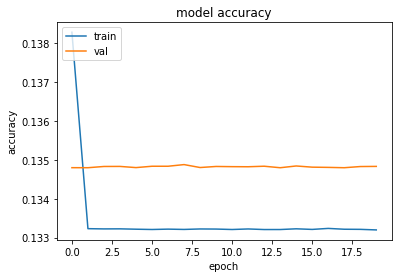

In [79]:
plt.plot(result.history['binary_crossentropy'])
plt.plot(result.history['val_binary_crossentropy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [68]:
model.evaluate(X_test, y_test)

27327/27327 [==============================] - 8s 291us/step - loss: 0.0865 - binary_crossentropy: 0.0865


[0.08646736294031143, 0.08646736294031143]

In [69]:
model.save(f'./saved_model/ffnn_{TARGET}')

INFO:tensorflow:Assets written to: ./saved_model/ffnn_reply/assets


## Predict

In [70]:
model = tf.keras.models.load_model(f'./saved_model/ffnn_{TARGET}')

In [80]:
pred = model.predict(X_test)

In [81]:
rce = compute_rce(pred, y_test)
rce

-0.00042965053279608867

In [74]:
average_precision_score(y_test, pred)

0.42356260668620216

In [76]:
X_test.columns

Index(['tweet_type', 'creator_follower_count', 'creator_following_count',
       'engager_follower_count', 'engager_following_count', 'media', 'dt_dow',
       'dt_hour', 'len_domains', 'creator_main_language',
       'engager_main_language', 'creator_and_engager_have_same_main_language',
       'is_tweet_in_creator_main_language',
       'is_tweet_in_engager_main_language',
       'engager_feature_number_of_previous_reply_engagement',
       'creator_feature_number_of_previous_reply_engagement',
       'number_of_engagements_positive',
       'number_of_engagements_positive_creator',
       'engager_number_of_engagements_ratio_reply',
       'number_of_engagements_ratio_reply'],
      dtype='object')